In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('C:/Users/burak/Desktop/Text-Classification-Models/Data/train.csv',delimiter=',',encoding='latin-1')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
""""df.drop(['review'],axis=1,inplace=True)
df.info()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-3-07d2aee428c0>, line 2)

In [5]:
df.author.unique()

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [6]:
df.author.unique().size

3

In [7]:
X = df.text
X2 = df.text
Y = df.author
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [8]:
X_train,X_test,X2_train,X2_test,Y_train,Y_test = train_test_split(X,X2,Y,test_size=0.33)

In [9]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
tok.fit_on_texts(X2_train)
sequences = tok.texts_to_sequences(X_train)
sequences2 = tok.texts_to_sequences(X2_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
sequences_matrix2 = sequence.pad_sequences(sequences2,maxlen=max_len)

In [10]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [11]:
model = RNN()
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 4)                

In [12]:
history = model.fit((sequences_matrix,sequences_matrix2),Y_train,batch_size=128,epochs=10,
          validation_split=0.2)

Epoch 1/10
82/82 [==============================] - 9s 106ms/step - loss: 1.1401 - accuracy: 0.3951 - val_loss: 1.0955 - val_accuracy: 0.4101
Epoch 2/10
82/82 [==============================] - 8s 98ms/step - loss: 1.0941 - accuracy: 0.3996 - val_loss: 1.0894 - val_accuracy: 0.4101
Epoch 3/10
82/82 [==============================] - 9s 110ms/step - loss: 1.0834 - accuracy: 0.3995 - val_loss: 1.0259 - val_accuracy: 0.4101
Epoch 4/10
82/82 [==============================] - 8s 103ms/step - loss: 0.8968 - accuracy: 0.5524 - val_loss: 0.7864 - val_accuracy: 0.6536
Epoch 5/10
82/82 [==============================] - 8s 96ms/step - loss: 0.6639 - accuracy: 0.7271 - val_loss: 0.7245 - val_accuracy: 0.6894
Epoch 6/10
82/82 [==============================] - 8s 93ms/step - loss: 0.5820 - accuracy: 0.7683 - val_loss: 0.6647 - val_accuracy: 0.7264
Epoch 7/10
82/82 [==============================] - 8s 93ms/step - loss: 0.5404 - accuracy: 0.7877 - val_loss: 0.6519 - val_accuracy: 0.7309
Epoch 8/10

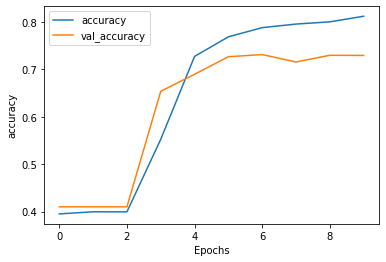

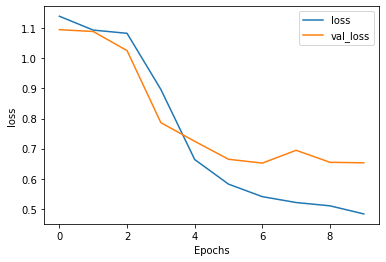

In [13]:
def graph_plots(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
graph_plots(history, "accuracy")
graph_plots(history, "loss")